In [311]:
import numpy as np
import camb
from matplotlib import pyplot as plt
import time
from tqdm.auto import tqdm

# 1. Run Jon's sample script to plot the power spectrum of the CMB

The $\chi^2$ value for the default parameters is 15267, which is fairly large, so probably not a very good fit.

chisq is  15267.937968194292  for  2501  degrees of freedom.


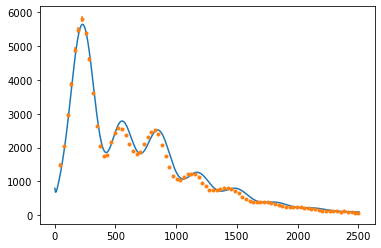

In [98]:
def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]

pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
planck=np.loadtxt('mcmc/COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('mcmc/COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

### Try fitting again with different initial guesses for parameters

We can see that $\chi^2$ improves by an order of magnitude (now 3272.2). I still wouldn't consider these values an acceptable fit since we can see that the variance is 6255001, which is still much too large an error bar for what we want for the fit.

chisq is  3272.203604462886  for  2501  degrees of freedom.


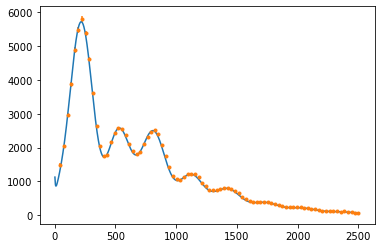

In [99]:
pars=np.asarray([69,0.022,0.12,0.06,2.10e-9,0.95])
planck=np.loadtxt('mcmc/COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('mcmc/COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

In [100]:
dof = len(resid)-len(pars)
var = dof**2

print("Mean of chi^2 is:", dof)
print("Variance of chi^2 is", var)

Mean of chi^2 is: 2501
Variance of chi^2 is 6255001


In [202]:
print(pars)

[6.76128759e+01 2.22013439e-02 1.18295357e-01 2.46443537e+04
 3.86602109e-09 9.59422321e-01]


# 2. Use Newton's method to find the best fit parameters, using numerical derivatives

### Function to take numerical derviatives:

This is the 2 point numerical derivative I wrote in PS1 but adapted in `partial_derivative` so that it is able to take arguments in order to compute partial derivatives.

To do the partial derivative, I use a wrapper (from my PS4 code) that evaluates the function we want to differentiate at each parameter as well as the array of parameters along the axis we're differentiating along. The optimal $\delta$ is $1/\sqrt{\varepsilon}$, but in this case, we need step sizes small enough so that $\tau$ converges, so we use a non-optimal $\delta$ = 1e-13.

$\chi^2$ from Newton's method is slightly larger but comparable to the LS fit using improved parameters above. I take into account the noise matrix here, which is just 1/variance of the errors given in the problem placed along the diagonal of a matrix. The errors are just the average of the upper (column 2 of the dataset) and lower (column 3) bounds of the error bars

In [213]:
def derivative(f,x,delta):
    return (1/(12*delta))*(f(x-2*delta)-8*f(x-delta)+8*f(x+delta)-f(x+2*delta))

def partial_derivative(func, var, point=[]):
    args = point[:]
    def wraps(x):
        args[var] = x
        return func(args)
    return derivative(wraps, point[var], delta = 1e-13)

In [370]:
def fit(func,p):
    y = func(p)
    grad=np.zeros([len(y),len(p)]) 
    for i in range(len(p)):
        grad[:,i] = partial_derivative(func,i,p)
    return y,grad

In [656]:
p0 = np.asarray([69.,0.022,0.12,0.06,2.10e-9,0.95])
p = p0.copy()
spec=planck[:,1]
err_avg = (planck[:,2]+planck[:,3])/2
Ninv= np.diag(1/err_avg**2)

for i in tqdm(range(7)):
    pred,grad = fit(get_spectrum,p)
    pred,grad = pred[:len(spec)],grad[:len(spec)]
    r = spec - pred
    err = np.sum(r**2)
    r=r.T
    grad = grad[:len(spec)]
    lhs=grad.T@Ninv@grad
    rhs=grad.T@Ninv@r
    dp=np.linalg.inv(lhs)@(rhs)
    for i in range(len(p)):
        p[i]=p[i]+dp[i]

  0%|          | 0/7 [00:00<?, ?it/s]

### Note that the covariance (curvature) matrix is calculated below - we'll use this for the MCMC in the next question!

In [657]:
cov = np.linalg.inv(lhs)
param_errs = np.sqrt(np.diag(cov))

print(f"Best-fit parameters are:\n\
H0 = {p[0]} +/- {param_errs[0]}\n\
Ωbh^2 = {p[1]} +/- {param_errs[1]}\n\
Ωch^2 = {p[2]} +/- {param_errs[2]}\n\
τ = {p[3]} +/- {param_errs[3]}\n\
As = {p[4]} +/- {param_errs[4]}\n\
ns = {p[5]} +/- {param_errs[5]}")

Best-fit parameters are:
H0 = 69.00259551783105 +/- 0.0003826488765396756
Ωbh^2 = 0.02199951565154579 +/- 6.357161383414019e-08
Ωch^2 = 0.11999955916739918 +/- 4.018629892439298e-08
τ = 0.08247408643159534 +/- 0.030853467319198837
As = 2.232716888071639e-09 +/- 1.4025755984955074e-10
ns = 0.9725744241242387 +/- 0.005219030675878392


#### Save output to `planck_fit_params.txt`

In [658]:
write = np.column_stack([p,param_errs])
file = 'planck_fit_params.txt'
np.savetxt(file , write, fmt=['%f','%f'])

<ErrorbarContainer object of 3 artists>

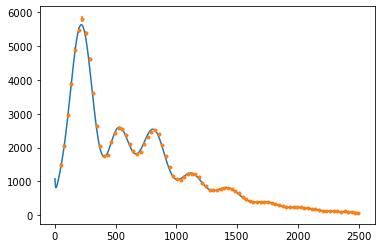

In [659]:
plt.plot(pred)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')

Text(0.5, 1.0, 'Residuals')

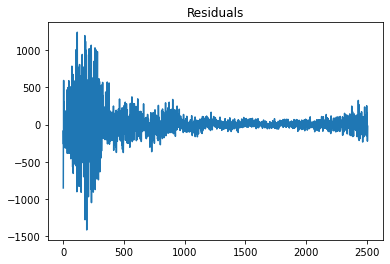

In [660]:
plt.plot(spec-pred)
plt.title("Residuals")

In [661]:
errs=0.5*(planck[:,2]+planck[:,3])
resid = spec-pred
chisq=np.sum((resid/errs)**2)
print("Chi^2 is:", chisq, "for", len(resid), "degrees of freedom")

Chi^2 is: 2757.862625093855 for 2507 degrees of freedom


# 3. Estimate parameters and error using an MCMC

The `mcmc` funtion is adapted from Jon's mcmc_class.py (from 2021 github). I added a constraint that $\tau$ must be > 0.1 in order for the CAMB package to stop throwing errors if $\tau$ becomes too large and therefore unphysical, $\tau$ shouold also be positive, so I added in a constraint to reject if it is ever < 0. 

I only used 5000 steps (ideally I'd want 10000+) because I was struggling all week trying to debug my $\tau$ and $n_s$ parameters running away from their expected magnitudes from Newton's method. In the interest of time, I decided to just run 5000 steps and finish the assignment with an unconverged chain rather than having nothing :)

If the chains are converged, the first plot should look like white noise and the second plot (power spectrum) should be flat at low k values - the left of the plot.

Neither of the plots look like this, and $n_s$ is still moving far away from where it should be, so, since the parameters are correlated, more iterations don't really produce any better results.

In [666]:
def calc_chisq(pars,data,err):
    pred=get_spectrum(pars)
    pred=pred[:len(err)]
    residuals = data-pred
    return np.sum((residuals/err)**2)

def mcmc(pars,err,y,cov,fun,scale,nstep):
    accept_num = 0
    chi_cur=fun(pars,y,err)
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep)
    for i in tqdm(range(nstep)):
        trial_pars=pars+scale*np.random.multivariate_normal(np.zeros(len(pars)),cov)
        trial_chisq=fun(trial_pars,y,err)
        delta_chisq=trial_chisq-chi_cur
        accept_prob=np.exp(-0.5*delta_chisq)
        accept=np.random.rand(1)<accept_prob

        if accept:
            accept_num = accept_num + 1
            pars=trial_pars
            chi_cur=trial_chisq
        chain[i,:]=pars
        chivec[i]=chi_cur
    return chain,chivec,accept_num

In [668]:
scale_vals = 1
p_new = p.copy()
chain2,chisq2,accept=mcmc(p_new,spec,errs,cov,calc_chisq,scale=scale_vals,nstep=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

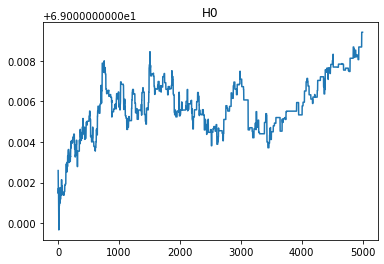

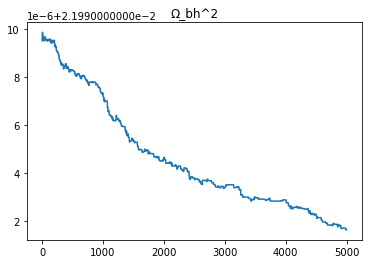

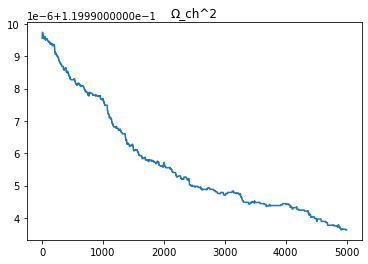

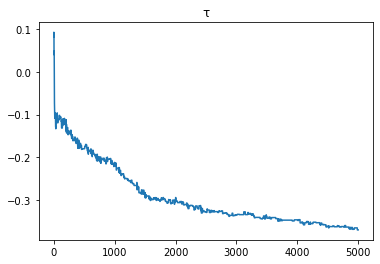

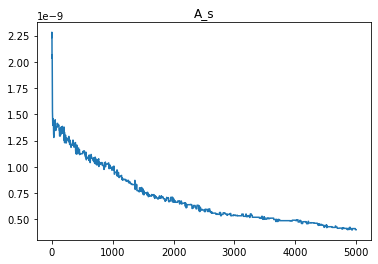

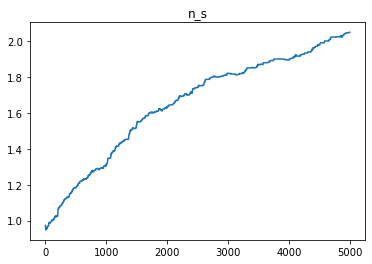

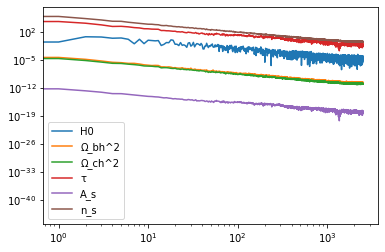

In [672]:
titles = np.asarray(['H0','Ω_bh^2','Ω_ch^2','τ','A_s','n_s'])
for i in range(len(p_new)):
    plt.plot(chain2[:,i])
    plt.title(titles[i])
    plt.show()
for i in range(6):
    ft_chain = np.abs(np.fft.rfft(chain2[:,i]-np.mean(chain2[:,i]))**2)
    plt.loglog(ft_chain)
plt.legend(['H0','Ω_bh^2','Ω_ch^2','τ','A_s','n_s'])

### Is this any better if we zoom in to the ends of the chains?

No, but it's not bouncing around like crazy or anything, so I think we can continue

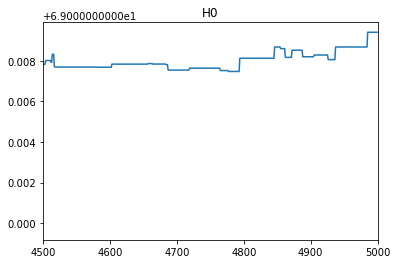

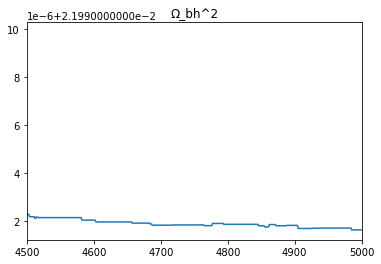

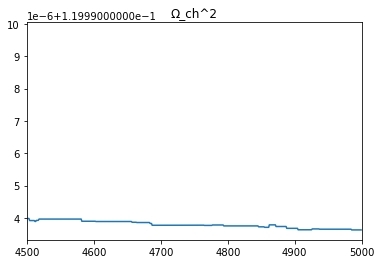

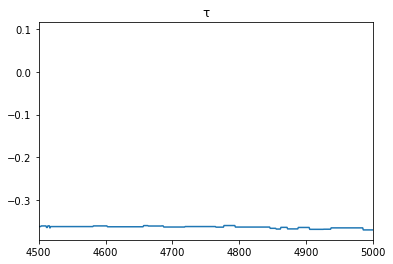

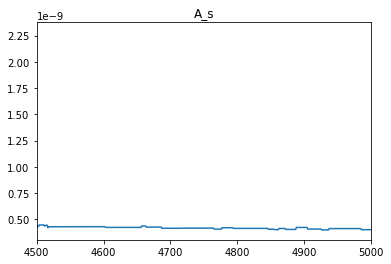

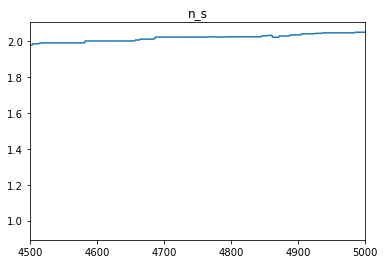

In [673]:
titles = np.asarray(['H0','Ω_bh^2','Ω_ch^2','τ','A_s','n_s'])
for i in range(len(p_new)):
    plt.plot(chain2[:,i])
    plt.title(titles[i])
    plt.xlim(4500,5000)
    plt.show()

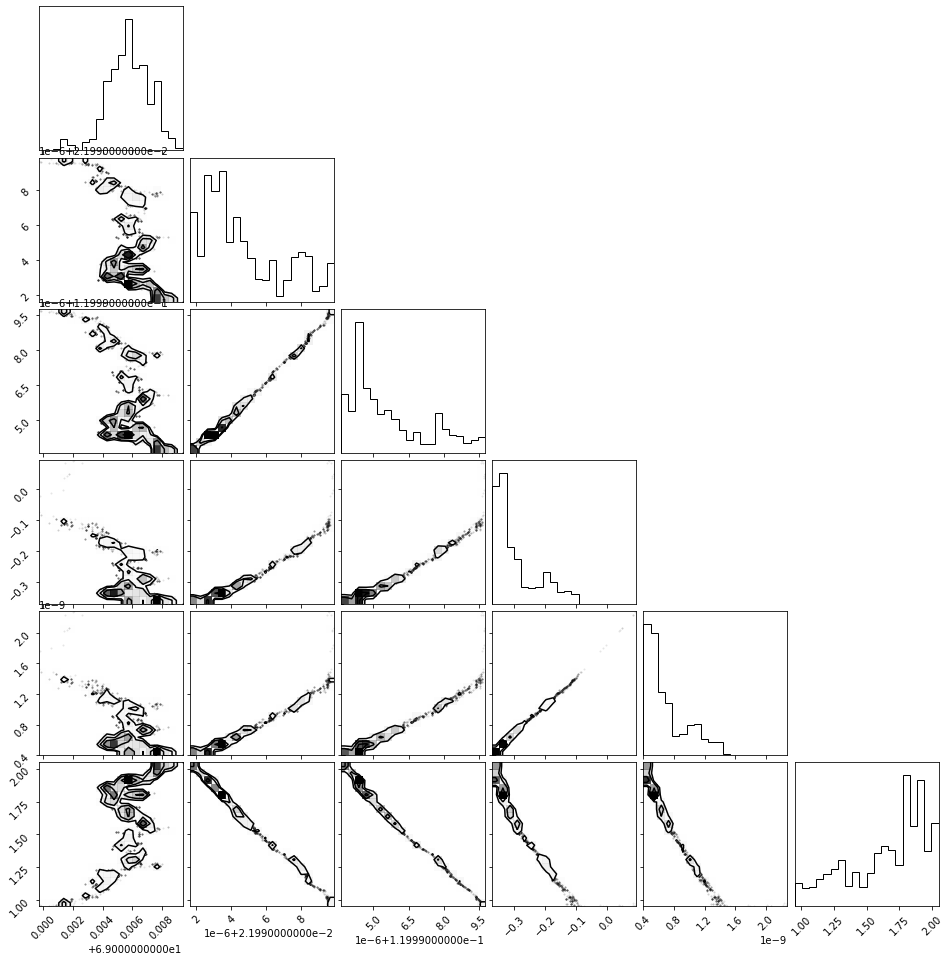

In [674]:
import corner
figure = corner.corner(chain2)

### Save chain to text file

In [676]:
mcmc_write = np.column_stack([chain2,chisq2])
mcmc_file = 'planck_chain.txt'
np.savetxt(mcmc_file , mcmc_write, fmt=['%f','%f','%f','%f','%f','%f','%f'])

### Calculate the parameters and errors from the average/std of the converged part of the MCMC chain

In [703]:
mcmcp = np.mean(chain2[4500:5000],axis=0)
mcmce = np.std(chain2[4500:5000],axis=0)

print(f"MCMC best-fit parameters are:\n\
H0 = {mcmcp[0]} +/- {mcmce[0]}\n\
Ωbh^2 = {mcmcp[1]} +/- {mcmce[1]}\n\
Ωch^2 = {mcmcp[2]} +/- {mcmce[2]}\n\
τ = {mcmcp[3]} +/- {mcmce[3]}\n\
As = {mcmcp[4]} +/- {mcmce[4]}\n\
ns = {mcmcp[5]} +/- {mcmce[5]}")

MCMC best-fit parameters are:
H0 = 69.0080142863614 +/- 0.0004417930181979411
Ωbh^2 = 0.021991879515911097 +/- 1.496922294700448e-07
Ωch^2 = 0.11999379063187567 +/- 1.0657011555891349e-07
τ = -0.36429926421939707 +/- 0.002493067559703605
As = 4.1873911042186683e-10 +/- 9.808733821763588e-12
ns = 2.020364732315966 +/- 0.01889960727008938


### Estimate on dark energy and its uncertainty

We know that $\Omega_b + \Omega_c + \Omega_\lambda = 1$, where h = $H_0/100$ and $\Omega_b$ and $\Omega_c$ are parameters in our chain.

$\Rightarrow \Omega_\lambda = 1 - \Omega_b - \Omega_c$

Error can be calculated by error propagation using partial derivatives (I used this resource: https://chem.libretexts.org/Bookshelves/Analytical_Chemistry/Supplemental_Modules_(Analytical_Chemistry)/Quantifying_Nature/Significant_Digits/Propagation_of_Error)

This shoudln't be negative, so there's clearly an error with the parameters from our MCMC

In [704]:
omega_b = mcmcp[1]
omega_b_err = mcmce[1]

h = mcmcp[0]
h_err = mcmce[0]

omega_c = mcmcp[2]
omega_c_err = mcmce[2]

omega_lambda = omega_b/((h/100)**2) - omega_c/((h/100)**2)
err_omega_lambda = (omega_b_err/omega_b + (2*h_err/h))*(omega_b/((h/100)**2)) + (omega_c_err/omega_c + (2*h_err/h))*(omega_c/((h/100)**2))

print("Energy density of dark energy is", omega_lambda, "+/-", err_omega_lambda)

Energy density of dark energy is -0.20579531488865443 +/- 4.355766377088003e-06


# 4. Run a new chain including polarization data constraint

Total likelihood = old likelihood (previous chain) * new likelihood

We can weight each chain sample by the new likelihood $\Rightarrow$ new distributions = weighted averages over chain 

The likelihood ratio is given by $e^{-\frac{1}{2} (\frac{\delta \tau}{\tau\ uncertainty})^2}$

The `process_chain` function is adapted from Jon's `mcmc_high_T.py`

In [705]:
def process_chain(chain,tau_prior,tau_prior_err):
    dchi=chain[:,3] - tau_prior

    wt=np.exp(-0.5*(dchi/tau_prior_err)**2) #the magic line that importance samples

    #calculate the weighted sum of the chain and the chain squared
    npar=chain.shape[1]
    tot=np.zeros(npar)
    totsqr=np.zeros(npar)
    for i in range(npar):
        tot[i]=np.sum(wt*chain[:,i])
        totsqr[i]=np.sum(wt*chain[:,i]**2)
    #divide by sum or weights
    mean=tot/np.sum(wt)
    meansqr=totsqr/np.sum(wt)

    #variance is <x^2>-<x>^2
    var=meansqr-mean**2
    return mean,np.sqrt(var),wt

In [706]:
mcmc_mean,mcmc_sig,weights = process_chain(chain2.T,0.0540,0.0074)

### Use these weights to compute a new covariance matrix before running our next chain and run a new chain starting at the end values of our chain from problem 3

We need to change the $\chi^2$ function slightly, so that we factor in $\chi^2$ associated with the difference between our parameter $\tau$ and the prior $0.054 \pm 0.0074$ - this is encompassed in the function `calc_chisq_tau` and we just run `mcmc`, the function from problem 3.

In [717]:
new_cov = np.cov(m=chain2,aweights=weights)

old_chain = chain2[:,-1]
p_tau = mcmcp.copy()
p_tau[3] = 0.054
print(p_tau)

def calc_chisq_tau(pars,data,err):
    pred=get_spectrum(pars)
    pred=pred[:len(err)]
    residuals = data-pred
    chisq = np.sum((residuals/err)**2)
    return chisq + ((pars[3]-0.054)/0.0074)**2

[6.90080143e+01 2.19918795e-02 1.19993791e-01 5.40000000e-02
 4.18739110e-10 2.02036473e+00]


In [709]:
chain_tau,chisq_tau,accept_tau=mcmc(p_tau,spec,errs,cov,calc_chisq_tau,scale=scale_vals,nstep=100)

  0%|          | 0/100 [00:00<?, ?it/s]

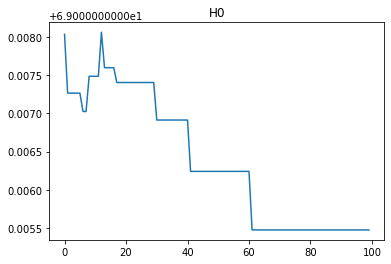

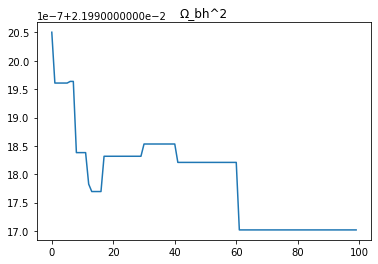

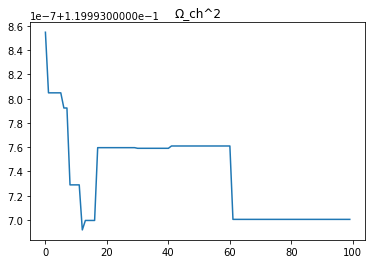

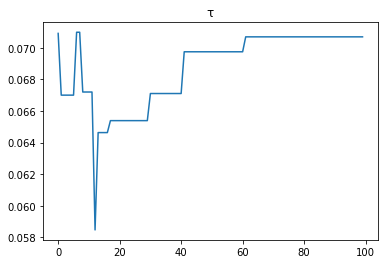

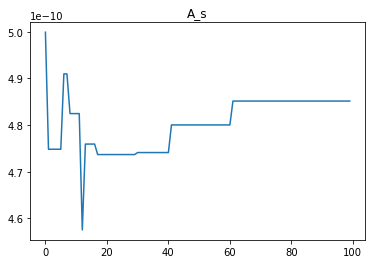

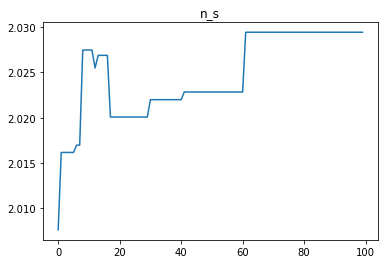

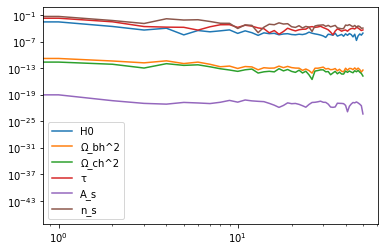

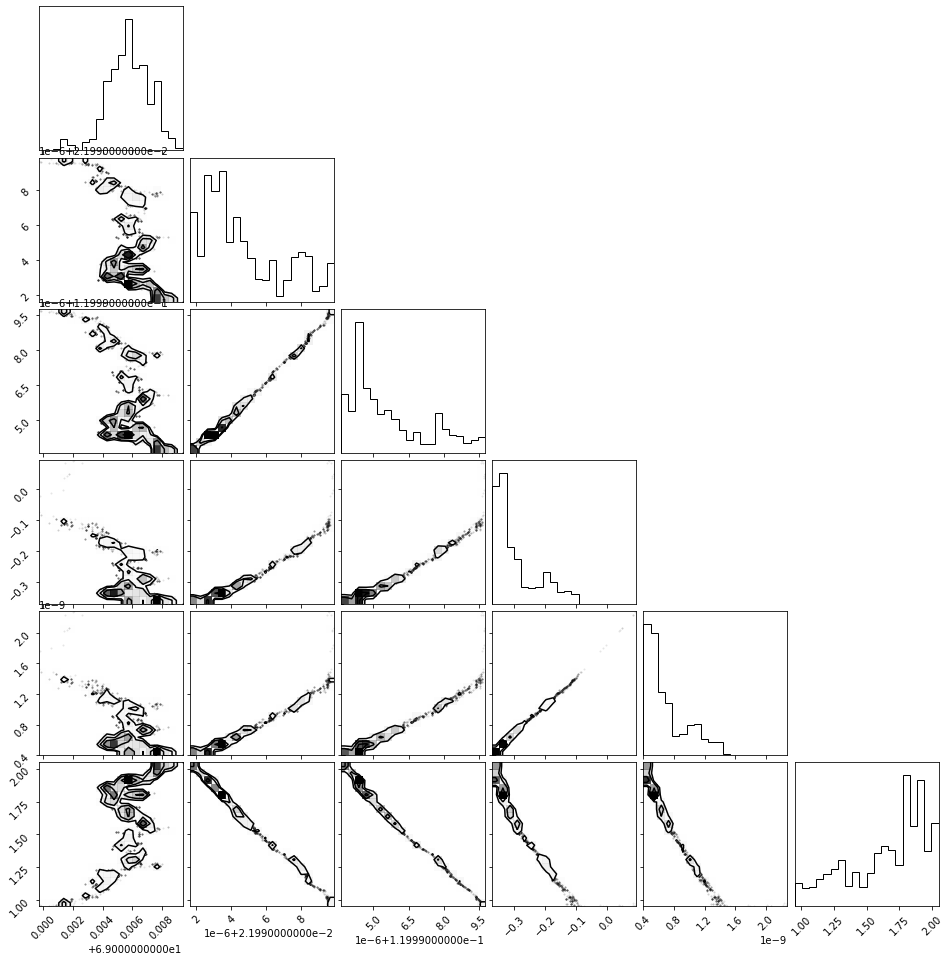

In [711]:
for i in range(len(p_new)):
    plt.plot(chain_tau[:,i])
    plt.title(titles[i])
    plt.show()
for i in range(6):
    ft_chain = np.abs(np.fft.rfft(chain_tau[:,i]-np.mean(chain_tau[:,i]))**2)
    plt.loglog(ft_chain)
plt.legend(['H0','Ω_bh^2','Ω_ch^2','τ','A_s','n_s'])
plt.show()
figure = corner.corner(chain2)

In [722]:
mcmc_tau = np.mean(chain_tau,axis=0)
mcmc_tau_err = np.std(chain_tau,axis=0)

print(f"MCMC best-fit parameters are (with τ prior):\n\
H0 = {mcmc_tau[0]} +/- {mcmc_tau_err[0]}\n\
Ωbh^2 = {mcmc_tau[1]} +/- {mcmc_tau_err[1]}\n\
Ωch^2 = {mcmc_tau[2]} +/- {mcmc_tau_err[2]}\n\
τ = {mcmc_tau[3]} +/- {mcmc_tau_err[3]}\n\
As = {mcmc_tau[4]} +/- {mcmc_tau_err[4]}\n\
ns = {mcmc_tau[5]} +/- {mcmc_tau_err[5]}")

MCMC best-fit parameters are (with τ prior):
H0 = 69.00637449580441 +/- 0.0008379169743202922
Ωbh^2 = 0.02199178988600887 +/- 8.207588479127709e-08
Ωch^2 = 0.11999373636198926 +/- 3.5532107683995074e-08
τ = 0.06873358618246474 +/- 0.0023589815275466683
As = 4.804164673916872e-10 +/- 5.737589464281155e-12
ns = 2.024734559166282 +/- 0.004610957982233009


In [720]:
tau_write = np.column_stack([chain2,chisq2])
tau_file = 'planck_chain_tauprior.txt'
np.savetxt(tau_file , tau_write, fmt=['%f','%f','%f','%f','%f','%f','%f'])

### Compare these with the values from problem 3:

H0 isn't statistically different, but the other values are. They shouldn't be, since the importance sampling should get us closer to the actual values by adding a new constraint. This is likely because my parameters from problem 3 aren't correct. 

In [725]:
print(f"MCMC best-fit parameters are (without τ prior):\n\
H0 = {mcmcp[0]+mcmc_mean[0]} +/- {mcmc_sig[0]}\n\
Ωbh^2 = {mcmcp[1]+mcmc_mean[1]} +/- {mcmc_sig[1]}\n\
Ωch^2 = {mcmcp[2]+mcmc_mean[2]} +/- {mcmc_sig[2]}\n\
τ = {mcmcp[3]+mcmc_mean[3]} +/- {mcmc_sig[3]}\n\
As = {mcmcp[4]+mcmc_mean[4]} +/- {mcmc_sig[4]}\n\
ns = {mcmcp[5]+mcmc_mean[5]} +/- {mcmc_sig[5]}")

MCMC best-fit parameters are (without τ prior):
H0 = 69.07684470000497 +/- 0.025277370540507448
Ωbh^2 = 0.09928366999793603 +/- 0.029844444964762996
Ωch^2 = 0.195503184223957 +/- 0.028882346598117527
τ = -0.2944301969877605 +/- 0.02583788798217511
As = 0.03639623060197444 +/- 0.0077706031787391616
ns = 2.0632277695894143 +/- 0.011261069429483987
